### <b>Washington State Crash Event Analysis</b>
#### --- by 

In [104]:
import pandas as pd
import numpy as np
import regex as re

import requests
import asyncio
import json as js

import time

import os

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 9)


#### <b>1. Explorative Data Analysis</b></br>
##### <b>1.1 Introduction to Datasets</b></br>
- <b>df_data_main</b>: The original data set with an expanded column that stores the zipcode of the place where the accident occured</br>
- <b> df_metadata_crashtype</b>: Derived from the table 6 of the original dataset. This dataframe contains all the metainfo about a category of crashtype</br>

In [105]:
dir = os.path.abspath(os.path.dirname(os.getcwd())) + '/data/'

df_data_main = pd.read_csv(
    dir + '/output/data_with_zipcode.csv').drop(axis=1, labels='Unnamed: 0')
df_data_main.event_zipcode = df_data_main.event_zipcode.astype(
    str)   # convert the default float type values into str

df_metadata_crashtype = pd.read_csv(
    dir + '/output/crash_type.csv').set_index(keys='type_index')

df_metadata_driver_factor = pd.read_csv(
    dir + '/output/driver_behavioral_factors.csv').drop(labels='Unnamed: 0', axis=1)

df_data_main.shape


C:\Users\Chaconne\AppData\Local\Temp\ipykernel_25696\3558271330.py:3: DtypeWarning: Columns (22,23,24,302,304) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data_main = pd.read_csv(


(4132, 306)

##### <b>1.2 Data Cleaning</b>

- The following blocks drop rows which do not have valid zipcodes (i.e. rows that do not have either a driver zipcode or an accident zipcode)

In [106]:
# drop rows which do not have an event zipcode

has_no_zipcode = df_data_main.event_zipcode.map(lambda v: v == 'nan')
df_data_main = df_data_main[df_data_main.event_zipcode != 'nan']
df_data_main.shape


(4132, 306)

In [107]:
# drop rows which do not have a person zipcode

df_data_main.dzip = df_data_main.dzip.map(
    lambda n: 0 if n == 0 else 0 if pd.isna(n) else int(n)
)
# valid zip codes are all 5 digit so we filter out those with less than 5 digits
df_data_main = df_data_main[(df_data_main.dzip > 10000)
                            & (df_data_main.dzip <= 99950)]
df_data_main.dzip = df_data_main.dzip.astype(str)
df_data_main.shape


(3996, 306)

- The following block cleans the <b>age</b> column. <br/>
- After observation we found that there are invalid age values such as 999 or 998, which, after cleaning, are replaced with the column mean (calculation of the mean is based on the column being filtered out of the abnomral values.)

In [108]:
age_filter = filter(lambda v: v > 0 and v < 100, df_data_main.age)
age_mean = round(np.mean(list(age_filter), dtype=float), 0)

df_data_main.age = df_data_main.age.map(
    lambda v: age_mean if v < 0 or v >= 100 else v
)


#### <b> 2. Solutions
##### <b>2.1 Among drivers involved in fatal crashes, what proportion are involved in crashes in communities where they live?</b>
- <b>Visualization note</b>: a barchart / pie chart to show the proportion of non-resident and resident crash cases.

In [109]:
df_data_main['is_resident'] = df_data_main.index.map(
    lambda i: df_data_main.event_zipcode[i] == df_data_main.dzip[i]
)

df_data_main['is_driver'] = df_data_main.index.map(
    lambda i: df_data_main.loc[i,
                               'ptype'] == 1 and df_data_main.loc[i, 'vnumber'] == 1
)

prop = len(df_data_main[(df_data_main.is_resident == True) & (
    df_data_main.is_driver == True)]) / float(len(df_data_main[df_data_main.is_driver == True]))

print('{prop:.4f}% of the drivers are from the community where the accident occured'.format(
    prop=prop * 100))


25.4780% of the drivers are from the community where the accident occured


Based on our analysis, <b>25.478%</b> of the drivers are from the community where the accident occured.

##### <b>2.2 <b>2.3 Are there differences in the <u>crash types</u> in those crashes among “residents” versus those deemed to be not “from” the area?</b>
- We will first take a look at the types of crashes among residents versus non-residents drivers. To that end, we load the metadata regarding crash types.

In [110]:
# this dataframe stores the meta info of the variable crashtype
df_metadata_crashtype.head()

,crash_type,category
type_index,,
0,No Impact,NOT CATEGORIZED
1,Drive Off Road,SINGLE DRIVER
2,Control/Traction Loss,SINGLE DRIVER
3,"Avoid Collision with Vehicle, Pedestrian, Animal",SINGLE DRIVER
4,Specifics Other,SINGLE DRIVER


In [111]:
map_crashtype_category = {  # maps a crashtype to its category
    k: v for k, v in zip(df_metadata_crashtype.index, df_metadata_crashtype.category)
}

map_crashtype_eng = {   # maps a crashtype index to its actual meaning
    k: v for k, v in zip(df_metadata_crashtype.index, df_metadata_crashtype['crash_type'])
}

df_data_main['crash_category'] = df_data_main.crashtype.map(
    map_crashtype_category)
df_data_main['crashtype_eng'] = df_data_main.crashtype.map(map_crashtype_eng)


In [112]:
df_data_crash = df_data_main.groupby(by=['crashtype', 'is_resident']).agg(
    case_count=pd.NamedAgg(column='par', aggfunc=len),
).reset_index()

# temporary dataframe for calculating total by is_resident
df_temp = df_data_main.groupby('is_resident').par.agg('count')
# print(df_temp)
non_resident_event_count = float(df_temp.iloc[0])
resident_event_count = float(df_temp.iloc[1])
del df_temp


def get_case_proportion(case_index: int, crash_dataframe: pd.DataFrame) -> float:
    is_resident = crash_dataframe.loc[case_index, 'is_resident']
    case_count = crash_dataframe.loc[case_index, 'case_count']
    if is_resident:
        ratio = case_count / resident_event_count
    else:
        ratio = case_count / non_resident_event_count
    return ratio


df_data_crash['case_proportion'] = df_data_crash.index.map(
    lambda i: get_case_proportion(i, df_data_crash))

df_data_crash


,crashtype,is_resident,case_count,case_proportion
0,0,False,18,0.005958
1,0,True,4,0.004103
2,1,False,241,0.079775
3,1,True,95,0.097436
...,...,...,...,...
100,98,False,555,0.183714
101,98,True,131,0.134359
102,99,False,1,0.000331
103,99,True,1,0.001026


- The following pivot table compares the proportion of different crash categories among the resident and non-resident groups.
- <b>Visualization note</b> There should be a paired bar chart to show the proportional differences of case categories across resident and non-resident groups

In [113]:
df_crash_pivoted = df_data_crash.pivot(
    index='crashtype', columns='is_resident', values=['case_proportion'])

df_crash_pivoted['diff'] = df_crash_pivoted[(
    'case_proportion', False)] - df_crash_pivoted[('case_proportion', True)]
df_crash_pivoted.sort_values(by='diff', ascending=False, inplace=True)
df_crash_pivoted.drop(axis=1, labels='diff', inplace=True)
df_crash_pivoted = df_crash_pivoted.fillna(0)

df_crash_pivoted['crashtype_eng'] = df_crash_pivoted.index.map(
    map_crashtype_eng)
df_crash_pivoted[:5]

case_proportion                         crashtype_eng
is_resident           False      True                            
crashtype                                                        
98                 0.183714  0.134359           Other Crash Type 
50                 0.068189  0.050256  Lateral Move (Left/Right) 
28                 0.008606  0.001026     Decelerating (Slowing) 
25                 0.016220  0.009231     Slower, Going Straight 
52                 0.013572  0.007179            Specifics Other

<AxesSubplot:xlabel='crashtype'>

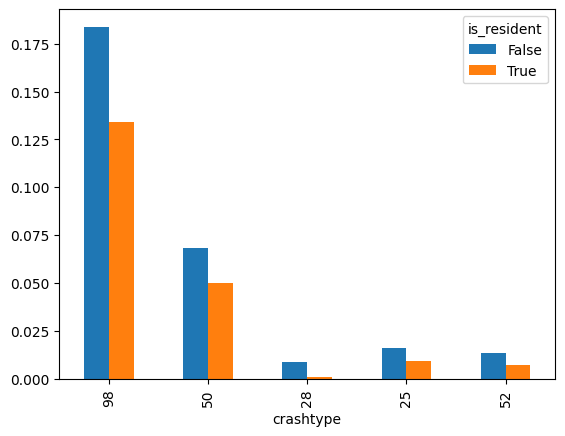

In [114]:
df_crash_pivoted.case_proportion[:5].plot(kind = 'bar')

- According to the pivot table, the largest difference of case proportion appears in the crash types<b>98, 50, 28, 25,52</b>, which are <b>Other Crash Type,  Lateral Move (Left/Right), Decelerating (Slowing), and Slower, Going Straight</b>.</br>

- We conclude that <b>there is a significantly high proportion of non-resident drivers who caused MISCELLANEOUS crash events</b>.</br>

##### <b>2.3 Are there differences in the <u>behavior factors</u> in those crashes among “residents” versus those deemed to be not “from” the area?

In [115]:
df_metadata_driver_factor = df_metadata_driver_factor.loc[
    df_metadata_driver_factor.effect_end >= df_data_main.year.min(), :
]   # filter out factors that do not take effect during the timeframe of the dataset

df_metadata_driver_factor = df_metadata_driver_factor.sort_values(
    by='factor_index', ascending=True).reset_index(drop=True)
df_metadata_driver_factor


,factor_index,driver_factor,effect_start,effect_end,factor_category
0,0,No factors identified for this driver,0,9999,default
1,4,Reaction to/Failure to take Drugs/Medication,0,9999,Physical/Mental Condition
2,6,Careless Driving,2012,9999,Physical/Mental Condition
3,8,Aggressive Driving Road Rage,2004,9999,Physical/Mental Condition
...,...,...,...,...,...
76,94,Emergency Medical Service Personnel,0,2019,Possible Distraction Inside Vehicle
77,95,Fire Personnel,0,2019,Possible Distraction Inside Vehicle
78,96,Tow Operator,0,2019,Possible Distraction Inside Vehicle
79,97,"Transportation i.e. maintenance workers, safte...",0,2019,Possible Distraction Inside Vehicle


In [116]:
def sum_driver_factor(index: int, df: pd.DataFrame):
    # first conerted to int to remove trailing decimal zero
    joint = '|'.join(df.loc[index, 'drf1':'drf4'].astype(int).astype(str))
    return re.sub(pattern=r'\|0', string=joint, repl='')


df_data_main.loc[:, 'drf1':'drf4'] = df_data_main.loc[:, 'drf1':'drf4'].fillna(
    0)     # in this case, na suggests no factor rather than the missing of value
df_data_main['drf'] = df_data_main.index.map(lambda i:
                                             sum_driver_factor(i, df_data_main)
                                             )

# drop the original component columns as we already acquired the summed up one
df_data_main.drop(
    axis=1, labels=['drf1', 'drf2', 'drf3', 'drf4'], inplace=True)


In [117]:
def get_factor_levels(factor_col):
    res = []
    for val in factor_col:
        val_split = val.split('|')
        for v in val_split:
            res.append(v)
    return sorted(np.unique(res))   # sort the levels


# stores the distinct values of drf
drf_distinct_vals = get_factor_levels(df_data_main.drf)


def factor_to_dummy(factor_col, level):
    col_len = len(factor_col)

    data_dict = {
        lv: [0] * col_len for lv in level
    }
    for i in range(col_len):
        keys = factor_col[i].split('|')
        for key in keys:
            data_dict[key][i] = 1
    return pd.DataFrame(data_dict)


df_drf_dist = factor_to_dummy(df_data_main.drf.values, drf_distinct_vals)
df_drf_dist.insert(0, 'is_resident', df_data_main.is_resident)
df_drf_dist = df_drf_dist.groupby('is_resident').agg('sum')
df_drf_dist.loc[0, :] = df_drf_dist.loc[0, :] / sum(df_drf_dist.loc[0, :])
df_drf_dist.loc[1, :] = df_drf_dist.loc[1, :] / sum(df_drf_dist.loc[1, :])
df_drf_dist = df_drf_dist.transpose()


df_drf_dist.columns = ['non-resident', 'resident']
df_drf_dist['diff'] = df_drf_dist['non-resident'] - df_drf_dist['resident']
df_drf_dist.sort_values(by='diff', inplace=True)
df_drf_dist.drop('diff', inplace=True, axis=1)
df_drf_dist.set_index(
    pd.Series(df_drf_dist.index, name='drf', dtype=int), inplace=True)
df_drf_dist[:5]

,non-resident,resident
drf,,
58,0.028470,0.038540
91,0.028146,0.034483
51,0.011970,0.017241
10,0.017147,0.022312
87,0.016500,0.021298


<AxesSubplot:xlabel='drf'>

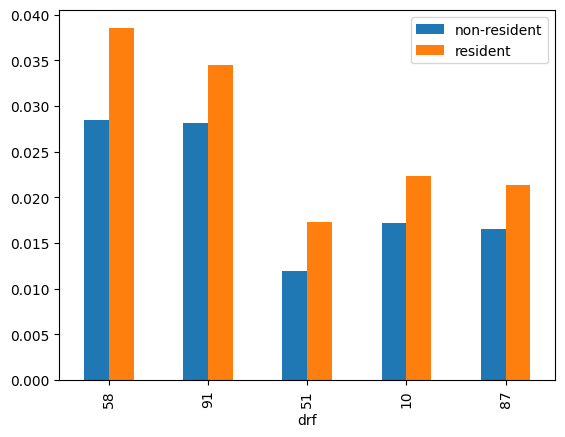

In [118]:
df_drf_dist[:5].plot(kind='bar')

- The table above suggests that compared to resident drivers, non-resident drviers are much more likely to encounter accidents that result from the behavioral factor <b>87</b>, that is, <b>Skidding, Swerving, Sliding Due To Ice, Water, Snow, Slush, Sand, Dirt, Oil, or Wet Leaves on Road</b>.

- The following blocks focus on the analysis of <b>distraction factors</b>. As the distraction index 0 means not distracted, and index 96 not reported, we merge these two categories into one.

In [119]:
df_data_main.loc[:, 'distract1': 'distract6'] = df_data_main.loc[:, 'distract1': 'distract6'].fillna(0)


def sum_distract_factors(ind: int, df: pd.DataFrame):
    return re.sub(string="|".join(df.loc[ind, 'distract1': 'distract6'].astype(int).astype(str)), pattern=r'\|0', repl='')


df_data_main['distract'] = df_data_main.index.map(
    lambda i: re.sub(string=sum_distract_factors(
        i, df_data_main), repl='0', pattern='96')
)

df_data_main.drop(axis=1, labels=[
                  'distract1', 'distract2', 'distract3', 'distract4', 'distract5', 'distract6'], inplace=True)
df_data_main.distract.value_counts(ascending=False)


0       3443
92       308
93       140
12        20
        ... 
5|93       1
14         1
3|6        1
97         1
Name: distract, Length: 20, dtype: int64

In [120]:
distinct_distract = get_factor_levels(df_data_main.distract)

df_distract = factor_to_dummy(df_data_main.distract.values, distinct_distract)
df_distract.insert(0, column='is_resident', value=df_data_main.is_resident)
df_distract = df_distract.groupby('is_resident').agg('sum')
df_distract.loc[0, :] = df_distract.loc[0, :] / sum(df_distract.loc[0, :])
df_distract.loc[1, :] = df_distract.loc[1, :] / sum(df_distract.loc[1, :])
df_distract = df_distract.transpose()
df_distract.columns = ['non-resident', 'resident']
df_distract['diff'] = df_distract['non-resident'] - df_distract['resident']
df_distract.sort_values(by='diff', inplace=True)
df_distract.drop('diff', inplace=True, axis=1)
df_distract.set_index(
    pd.Series(df_distract.index, name='distract_factor', dtype=int), inplace=True)
df_distract[:5]


,non-resident,resident
distract_factor,,
0,0.857045,0.876333
17,0.001365,0.005330
6,0.003412,0.004264
3,0.002388,0.003198
99,0.001365,0.002132


##### <b>2.4 Are there specific resident ZIP Codes that tend to produce higher-risk drivers that are involved in fatal crashes at a higher rate?</b>

In [121]:
df_data_by_zip = df_data_main.groupby('dzip').agg(
    case_count=pd.NamedAgg(column='par', aggfunc=len),
    case_proportion=pd.NamedAgg(
        column='par', aggfunc=lambda c: len(c) / len(df_data_main.index))
)
df_data_by_zip.sort_values(ascending=False, inplace=True, by='case_proportion')

df_data_by_zip.describe()


,case_count,case_proportion
count,693.000000,693.000000
mean,5.766234,0.001443
std,7.252280,0.001815
min,1.000000,0.000250
25%,1.000000,0.000250
50%,2.000000,0.000501
75%,8.000000,0.002002
max,47.000000,0.011762


In [122]:
risky_zipcode = df_data_by_zip[df_data_by_zip.case_proportion >=
                               0.001443 + 3 * 0.001815].index
risky_zipcode


Index(['99301', '98444', '98387', '98003', '98951', '98837', '98404', '98391',
       '98258', '98901', '98223', '98584', '99206', '98022'],
      dtype='object', name='dzip')

<AxesSubplot:ylabel='case_proportion'>

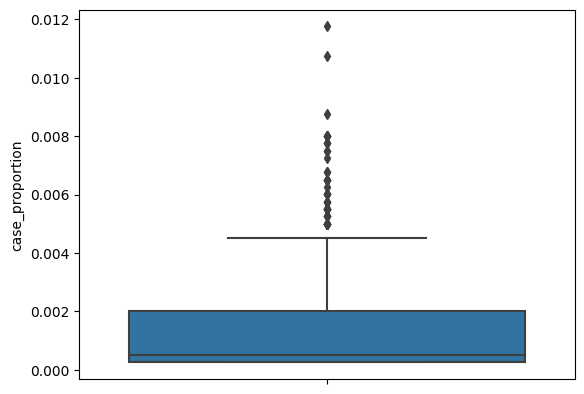

In [123]:
sns.boxplot(y=df_data_by_zip.case_proportion)


<AxesSubplot:xlabel='case_proportion', ylabel='Count'>

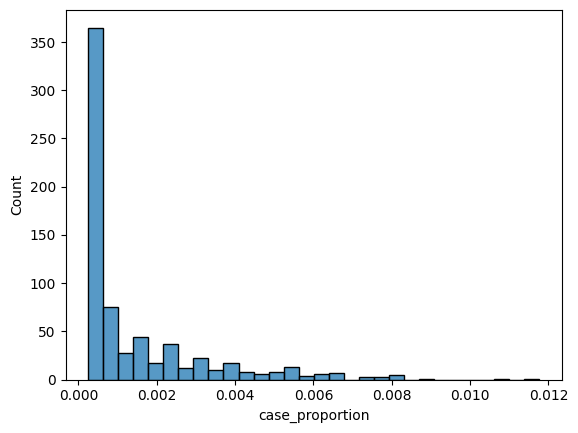

In [124]:
sns.histplot(x=df_data_by_zip.case_proportion)


##### <b>2.5 What are the population demographics of these high-risk driver producing ZIP Codes?</b>

In [125]:
# filter records related to risky zipcodes
df_data_risky_zipcode = df_data_main.loc[
    df_data_main.dzip.map(lambda zip: zip in risky_zipcode), :
]

print(df_data_risky_zipcode.shape)
df_data_risky_zipcode.head()

(467, 302)


,year,case,par,repjur,crash_dt,crash_tm,accday,accmon,holiday,county,...,CoMP,IntCoRoadName,IntCoMP,event_zipcode,is_resident,is_driver,crash_category,crashtype_eng,drf,distract
13,2017,10,E632128,8.0,01/08/2017,19:05,8,1,0.0,45,...,NaN,NaN,NaN,98546,False,True,"SAME TRAFFICWAY, OPPOSITE DIRECTION",Lateral Move (Left/Right),28,0
40,2017,26,E635844,1.0,01/23/2017,17:19,23,1,0.0,21,...,NaN,NaN,NaN,99344,False,False,"SAME TRAFFICWAY, OPPOSITE DIRECTION",Lateral Move (Going Straight),0,0
41,2017,26,E635844,1.0,01/23/2017,17:19,23,1,0.0,21,...,NaN,NaN,NaN,99344,False,False,MISCELLANEOUS,Other Crash Type,0,0
51,2017,34,E637343,1.0,01/24/2017,23:20,24,1,0.0,77,...,NaN,NaN,NaN,98951,False,False,"SAME TRAFFICWAY, OPPOSITE DIRECTION",Specifics Other,0,0
59,2017,40,E633587,25.0,01/16/2017,15:51,16,1,0.0,33,...,NaN,NaN,NaN,98022,True,True,SINGLE DRIVER,Drive Off Road,0,0


Text(0.5, 1.0, 'age distribution')

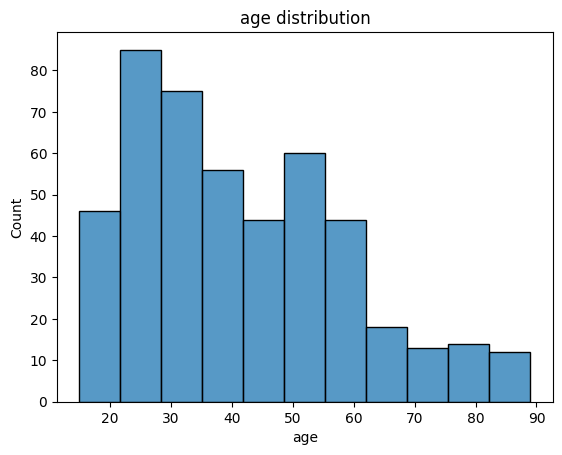

In [126]:
sns.histplot(x=df_data_risky_zipcode.age, ).set_title('age distribution')

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_25696\1739011886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_risky_zipcode.sex = df_data_risky_zipcode.sex.map(lambda s: 3 if s != 1 and s != 2 else s).map(


<AxesSubplot:xlabel='sex'>

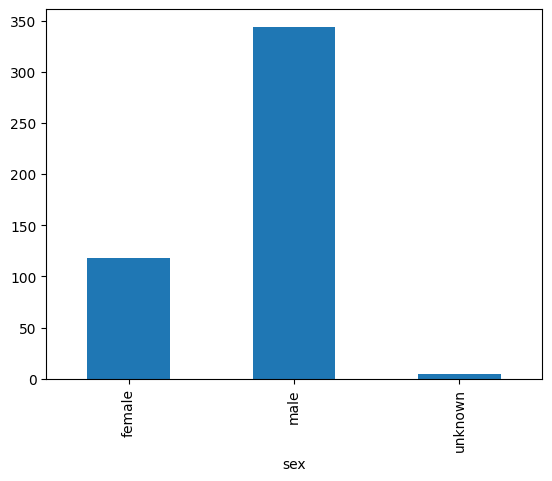

In [127]:
df_data_risky_zipcode.sex = df_data_risky_zipcode.sex.map(lambda s: 3 if s != 1 and s != 2 else s).map(
    {1: 'male', 2: 'female', 3: 'unknown'}
)

df_data_risky_zipcode.groupby('sex').agg('count').par.plot(kind='bar')


In [128]:
print(
    df_data_risky_zipcode.loc[:, 'race1':'race4'].apply(
        lambda c: sum(c.isna()))
)


race1    159
race2    463
race3    467
race4    467
dtype: int64


##### Output Cleaned Dataset for Visualization

In [129]:
df_data_main.to_csv(dir + 'output/data_vis.csv')
